In [359]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.titleweight"] = "bold"
sns.set_style("whitegrid")
sns.set_palette("inferno")

In [360]:
colnames = ["Price", "Area", "Ownership", "NRooms", "Status", "Floor", "Balcony", "Terrace", "Garden", "Rent", "Garage", "BuildYear", "Lift", "City", "Longitude", "Latitude"]

In [361]:
df = pd.read_csv("otodom_krk_raw.csv", header=None, names=colnames)
df.head()

,Price,Area,Ownership,NRooms,Status,Floor,Balcony,Terrace,Garden,Rent,Garage,BuildYear,Lift,City,Longitude,Latitude
0,1250000,77.00,-1,3,-1,floor_no::floor_3,0,0,0,500,-1,2007,::n,krakow,19.941979,50.051057
1,932822,60.12,-1,3,construction_status::to_completion,floor_no::floor_1,0,0,1,-1,extras_types-85::garage,2024,::n,krakow,19.881340,50.016400
2,719000,39.00,-1,2,construction_status-67::ready_to_use,floor_no::ground_floor,0,0,0,500,-1,-1,::n,krakow,19.908257,50.020627
3,779000,50.47,-1,3,construction_status-67::ready_to_use,floor_no::floor_4,1,0,0,-1,extras_types-85::garage,1977,::y,krakow,19.927940,50.017480
4,-1,52.48,-1,2,construction_status::to_completion,floor_no::floor_2,1,0,1,-1,extras_types-85::garage,2025,::y,krakow,19.899965,50.084740


In [362]:
df = df.replace("-1", np.nan).replace(-1, np.nan)

# Missing values

The majority of missing values are in **Rent** column, which actually is not that important, so it is going to be dropped.<br>
In terms of the **Price** column - I am going to drop all the rows with missing values there, I don't want to add another noise to the dataset, especially when there is that many of them.<br>
Rows with missing **Balcony**, **Terrace**, **Lift**, **Garage** columns are just indicating that there is a lack of these features in the flat, so I am going to fill them with **0s**.<br>
Missing value for **Ownership** probably tells us that it was obvious for the seller that the ownership is full, so there was no need to state the other way, I am going to fill the missing values with **1s**. The same for **Status** column.<br>
**BuildYear's** missing values are going to be filled with grouped correlated values created by some sort of **Imputer**.

---

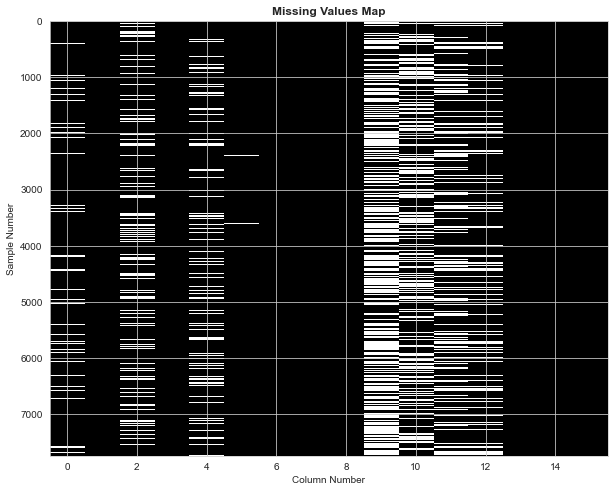

In [363]:
plt.figure(figsize=(10, 8))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number");
plt.title("Missing Values Map", weight="bold")
plt.show()

### Rent column
---

In [364]:
df = df.drop("Rent", axis=1)

### Price column
---

In [365]:
df = df[~df["Price"].isna()]

### Lift column
---

In [366]:
df["Lift"] = df["Lift"].fillna("0").replace("::y", "1").replace("::n", "0")

### Garage column
---

In [367]:
df["Garage"] = df["Garage"].fillna("0").replace("extras_types-85::garage", "1")

### Ownership column
---

In [368]:
df["Ownership"] = df["Ownership"].fillna("1").apply(lambda x: "1" if x == "building_ownership::full_ownership" else "0")

### Status column
---

In [369]:
df["Status"] = df["Status"].fillna("1").apply(lambda x: "1" if x == "construction_status-67::ready_to_use" else "0")

### Floor column
---

In [370]:
def convert_floor(floor_string: str) -> str:
    try:
        res = floor_string[10:]
        if res in ["floor_10", "floor_higher_10", "garret"]:
            return "10"
        elif res == "ground_floor":
            return "0"
        else:
            return res[6:]
    except:
        return floor_string

In [371]:
df["Floor"] = df["Floor"][~df["Floor"].isin(["floor_no::cellar"])].apply(lambda x: convert_floor(x))

In [372]:
df = df[~df["Floor"].isna()]

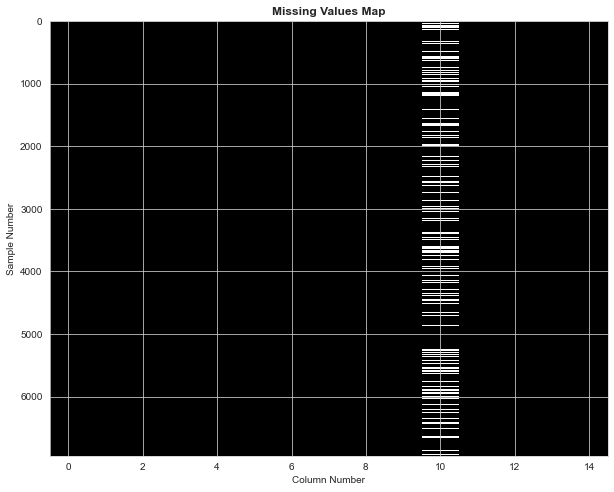

In [373]:
plt.figure(figsize=(10, 8))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number");
plt.title("Missing Values Map", weight="bold")
plt.show()

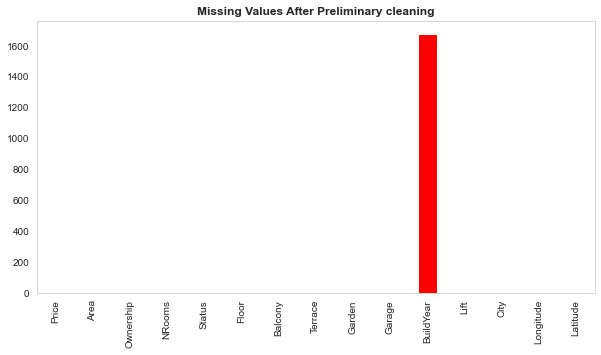

In [374]:
plt.figure(figsize=(10,5))
df.isna().sum().plot(kind="bar", color="red")
plt.title("Missing Values After Preliminary cleaning", weight="bold")
plt.grid()
plt.show()

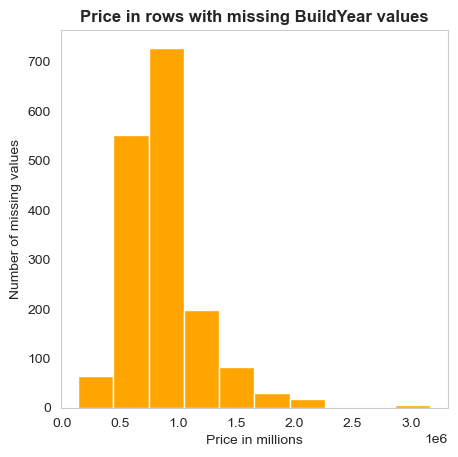

In [375]:
fig, ax = plt.subplots(figsize=(5,5), dpi=100)

df[df["BuildYear"].isna()]["Price"].plot(kind="hist", ax=ax, color="orange")
ax.grid()
ax.set_xlabel("Price in millions")
ax.set_ylabel("Number of missing values")
ax.set_title("Price in rows with missing BuildYear values", weight="bold")
plt.show()

# Let's have a little insight on the data

Before I decide what to really do with **BuildYear** missing values, I need to see how the data looks like a little bit.

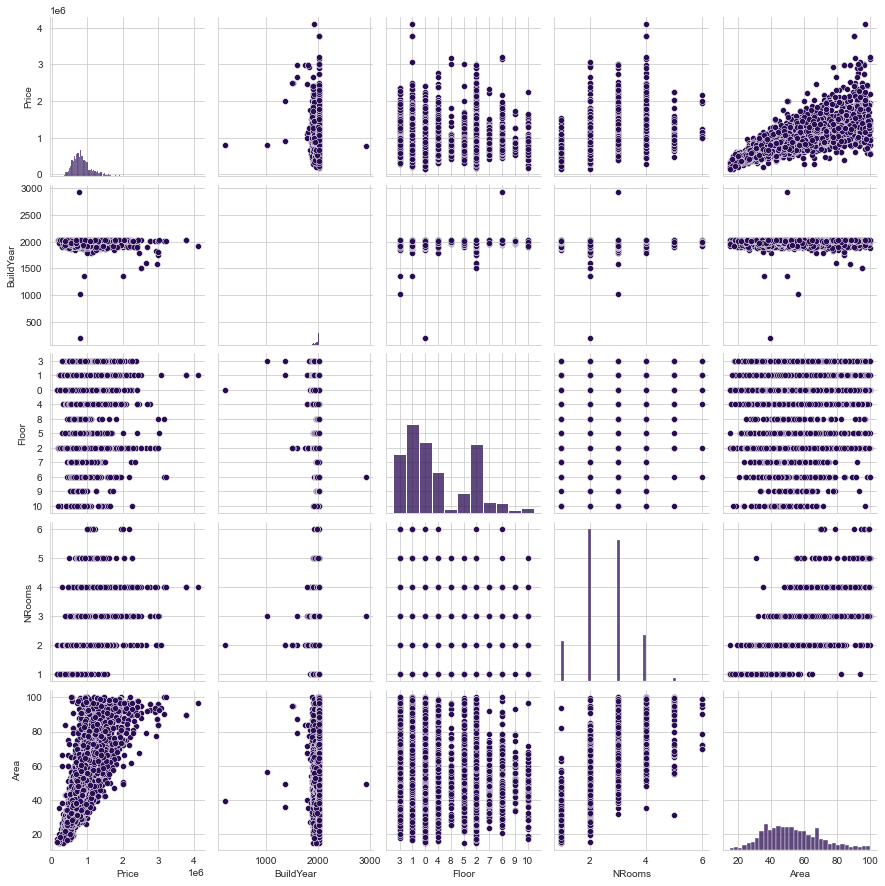

In [376]:
sns.pairplot(df, vars=["Price", "BuildYear", "Floor", "NRooms", "Area"])
plt.show()

# First steps
The key insights gathered from a simple visualization for each feature:<br>
- **Price**:<br>
&emsp; I need to take care of outliers, especially knowing that I want my model to be created for prices not higher than 1.5m, I should also check the lower values that are biased.
- **BuildYear**:<br>
&emsp; Apart from imputing missing data, I can see huge outliers in both directions, It would be probably a good choice to put the values into buckets rather than leave the years alone.
- **Floor**:<br>
&emsp; Higher floors are the minority in the dataset, I should probably put all of them into one bucket.
- **NRooms**:<br>
&emsp; There are only a few instances of flats with 5 or 6 rooms, I should think about the solution for this problem (bucketing or dropping)
- **Area**:<br>
&emsp; Area is filtered right-away by the site filters, however I need to fix the Area-NRooms correlation, where I can see interesting outliers.
---

## Price
---

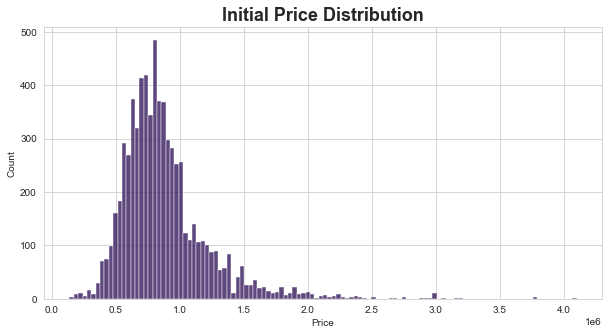

In [377]:
sns.histplot(data=df, x="Price")
plt.title("Initial Price Distribution", weight="bold", fontsize=18)
plt.show()

In [378]:
no_more_1500k = df[df["Price"] > 1500000]
no_less_150k  = df[df["Price"] < 150000]
print(f"There are {no_more_1500k.shape[0]} records with price higher than 1.5m")
print(f"There are {no_less_150k.shape[0]} records with price less than 150k")

There are 355 records with price higher than 1.5m
There are 3 records with price less than 150k


In [379]:
df = df[(df["Price"] >= 150000) & (df["Price"] <= 1500000)]

In [380]:
df.shape[0]

6586

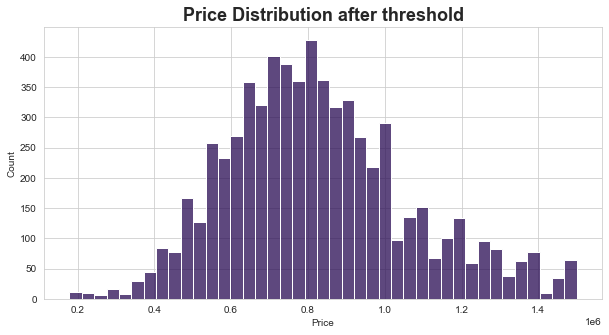

In [381]:
sns.histplot(data=df, x="Price")
plt.title("Price Distribution after threshold", weight="bold", fontsize=18)
plt.show()

## Floor
---

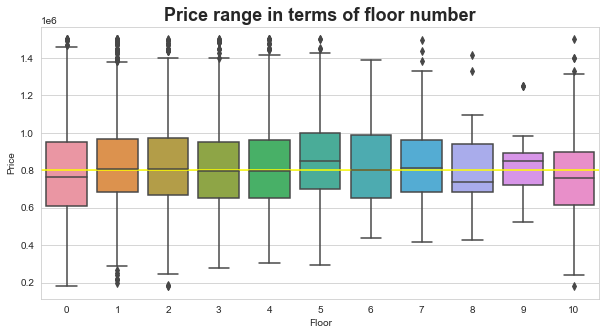

In [382]:
sns.boxplot(data=df, x="Floor", y="Price", order=sorted(df["Floor"].unique(), key=lambda x: int(x)))
plt.title("Price range in terms of floor number", weight="bold", fontsize=18)
plt.axhline(y=df["Price"].median(), color="yellow")
plt.show()

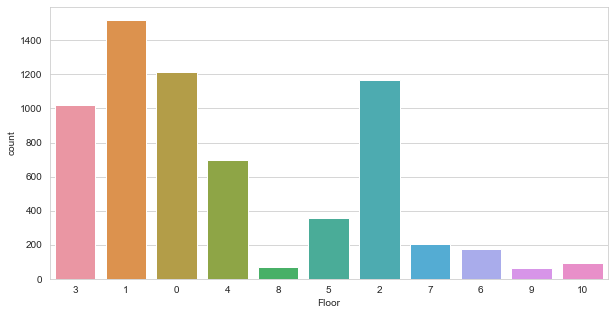

In [383]:
sns.countplot(data=df, x="Floor")
plt.show()

### NRooms
---

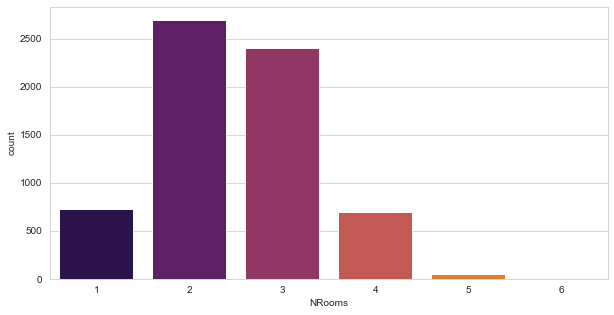

In [384]:
sns.countplot(data=df, x="NRooms")
plt.show()

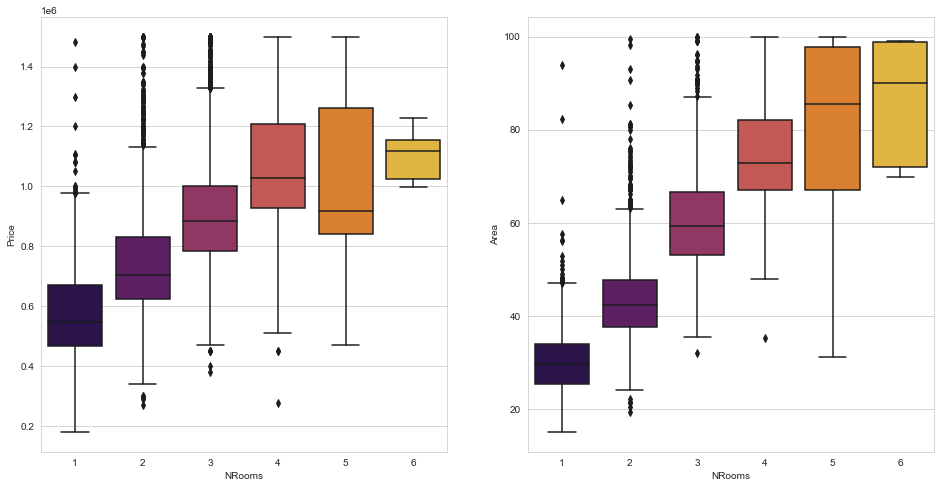

In [385]:
fig, axes = plt.subplots(figsize=(16, 8), ncols=2)

sns.boxplot(data=df, x="NRooms", y="Price", ax=axes[0])
sns.boxplot(data=df, x="NRooms", y="Area", ax=axes[1])
plt.show()

In [386]:
df["Ownership"] = df["Ownership"].astype("int")
df["Status"] = df["Status"].astype("int")
df["Floor"] = df["Floor"].astype("int")
df["Lift"] = df["Lift"].astype("int")

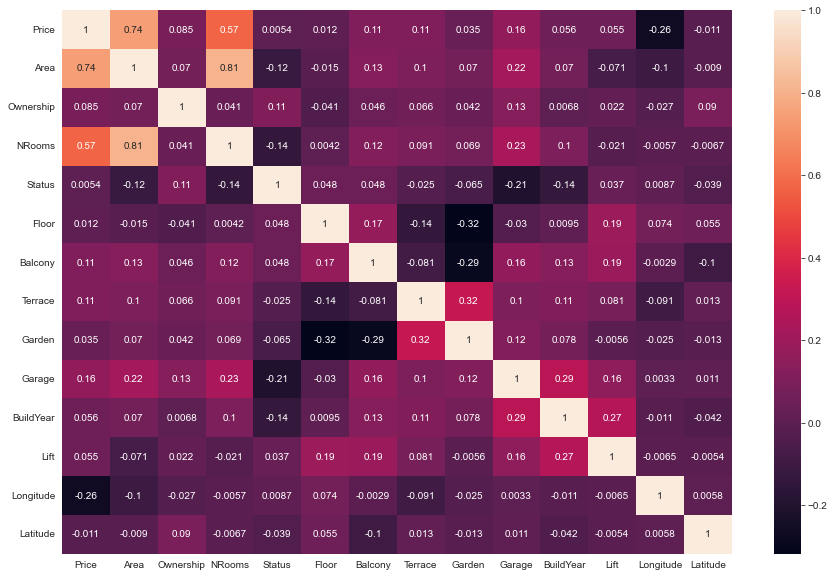

In [387]:
plt.figure(figsize=(15,10))
df["Garage"] = df["Garage"].astype("int")
sns.heatmap(df.corr(), annot=True)
plt.show()

### BuildYear
---

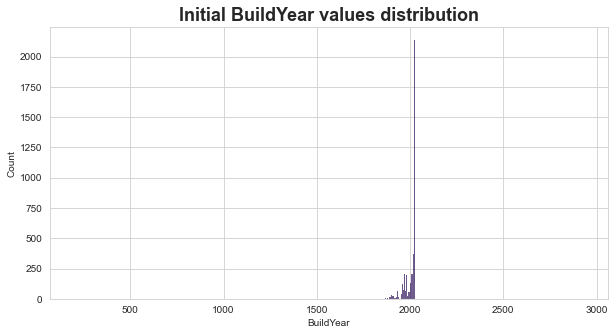

In [388]:
sns.histplot(data=df, x="BuildYear")
plt.title("Initial BuildYear values distribution", weight="bold", fontsize=18)
plt.show()

In [389]:
df.loc[df["BuildYear"] > 2024, "BuildYear"] = 2024

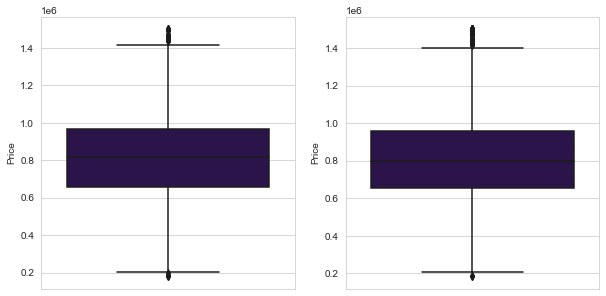

In [390]:
fig, axes = plt.subplots(ncols=2)

sns.boxplot(data=df[df["BuildYear"].isna()], y="Price", ax=axes[0])
sns.boxplot(data=df[~df["BuildYear"].isna()], y="Price", ax=axes[1])
plt.show()

In [391]:
df = df[(df["BuildYear"] > 1850) | (df["BuildYear"].isna())]
df.shape

(6577, 15)

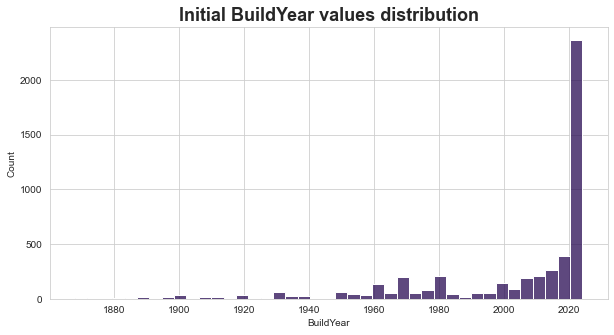

In [392]:
sns.histplot(data=df, x="BuildYear")
plt.title("Initial BuildYear values distribution", weight="bold", fontsize=18)
plt.show()

# Creating a simple model in order to impute BuildYear

I will try to make a simple linear model basing on the most correlated features to impute BuildYear. 

I am going to use:
- **Garage** (0.29)
- **Lift** (0.27)
- **Balcony** (0.13)
- **Terrace** (0.11)

 ---

In [401]:
X_lr = df.loc[~df["BuildYear"].isna(), ["Garage", "Balcony", "Terrace", "Lift", "NRooms"]].values
y_lr = df.loc[~df["BuildYear"].isna(), ["BuildYear"]].values

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.1, random_state=42)

lr = LinearRegression()
cv_ridge = GridSearchCV(Ridge(),
                        {"alpha": [0.01, 0.05, 0.1, 0.15, 0.2]},
                        cv=10,
                        scoring="neg_root_mean_squared_error")

cv_lasso = GridSearchCV(Lasso(),
                        {"alpha": [0.01, 0.05, 0.1, 0.15, 0.2]},
                        cv=10,
                        scoring="neg_root_mean_squared_error")

cv_tree = GridSearchCV(DecisionTreeRegressor(),
                       {"max_depth": [6, 8, 10, 12, 14, 16, 24, 32, 48]},
                       cv=10,
                       scoring="neg_root_mean_squared_error")

cv_ridge.fit(X_lr, y_lr)
cv_lasso.fit(X_lr, y_lr)
cv_tree.fit(X_lr, y_lr)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [6, 8, 10, 12, 14, 16, 24, 32, 48]},
             scoring='neg_root_mean_squared_error')

In [402]:
print("Linear Regression")
print(np.mean(-cross_val_score(lr, X_lr, y_lr, scoring="neg_mean_absolute_error", cv=10)))
print(np.mean(-cross_val_score(lr, X_lr, y_lr, scoring="neg_root_mean_squared_error", cv=10)), "\n")

print("Ridge")
print(np.mean(-cross_val_score(cv_ridge.best_estimator_, X_lr, y_lr, scoring="neg_mean_absolute_error", cv=10)))
print(np.mean(-cross_val_score(cv_ridge.best_estimator_, X_lr, y_lr, scoring="neg_root_mean_squared_error", cv=10)), "\n")

print("Lasso")
print(np.mean(-cross_val_score(cv_lasso.best_estimator_, X_lr, y_lr, scoring="neg_mean_absolute_error", cv=10)))
print(np.mean(-cross_val_score(cv_lasso.best_estimator_, X_lr, y_lr, scoring="neg_root_mean_squared_error", cv=10)), "\n")

print("Decision Tree")
print(np.mean(-cross_val_score(cv_tree.best_estimator_, X_lr, y_lr, scoring="neg_mean_absolute_error", cv=10)))
print(np.mean(-cross_val_score(cv_tree.best_estimator_, X_lr, y_lr, scoring="neg_root_mean_squared_error", cv=10)), "\n")

Linear Regression
17.84530488677494
25.26602597320565 

Ridge
17.84538395148594
25.266014408756757 

Lasso
17.84421637555234
25.26598040101391 

Decision Tree
16.933758058650263
24.960856318740372 



In [403]:
lr.fit(X_train_lr, y_train_lr)
y_pred_lr = lr.predict(X_test_lr)
y_pred_lr[y_pred_lr > 2024] = 2024
mean_absolute_error(y_test_lr, y_pred_lr)
#root_mean_squared_error(y_test_lr, y_pred_lr)

17.592150879220853

In [404]:
tree = cv_tree.best_estimator_
tree.fit(X_train_lr, y_train_lr)
y_pred_tree = tree.predict(X_test_lr)
y_pred_tree[y_pred_tree > 2024] = 2024
mean_absolute_error(y_test_lr, y_pred_tree)
#root_mean_squared_error(y_test_lr, y_pred_tree)

16.916874726500925

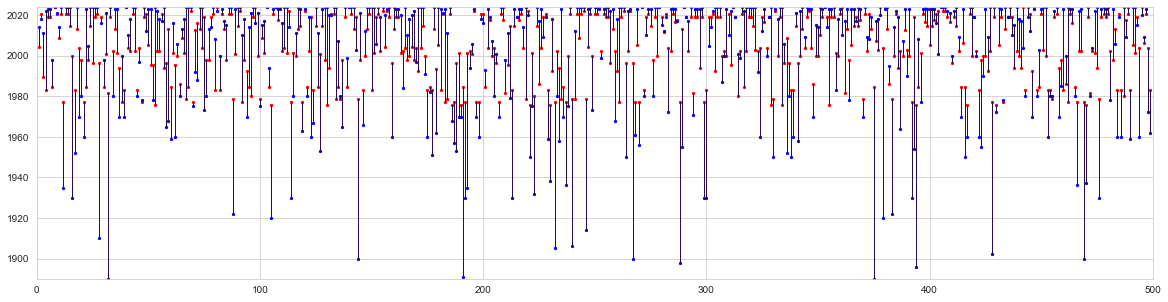

In [405]:
def plot_residual_error(y_test: np.array, y_pred: np.array, colors: list = ["red", "blue"], points: bool = True, lines: bool = True, linewidth: int = 1) -> None:
    points = True if not lines else points
    y_pred = y_pred.reshape(-1, 1)
    size = y_test.shape[0]

    y_lims = [min(np.min(y_pred), np.min(y_test)), max(np.max(y_pred), np.max(y_test))]
    x_lims = [0, size + 1]

    y_range = y_lims[1] - y_lims[0]

    plt.figure(figsize=(20,5))
    if points:
        plt.scatter(np.arange(1, size+1), y_pred, c=colors[0], s=5)
        plt.scatter(np.arange(1, size+1), y_test, c=colors[1], s=5)
    plt.ylim(y_lims)
    plt.xlim(x_lims)
    if lines:
        y_pred = y_pred.flatten()
        y_test = y_test.flatten()
        for i in range(1, size+1):
            yp = y_pred[i-1]
            yt = y_test[i-1]
                
            
            plt.axvline(x=i,
                        ymin=(min(yp, yt)-y_lims[0])/y_range,
                        ymax=(max(yp, yt)-y_lims[0])/y_range,
                        linewidth=linewidth)

    plt.show()
    
plot_residual_error(y_test_lr, y_pred_lr, points=True, linewidth=1)

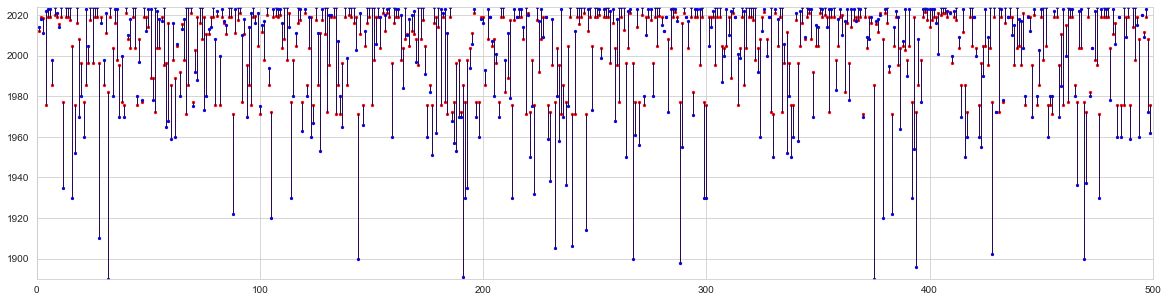

In [406]:
plot_residual_error(y_test_lr, y_pred_tree)

In [408]:
df.loc[df["BuildYear"].isna(), "BuildYear"] = tree.predict(df[df["BuildYear"].isna()][["Garage", "Balcony", "Terrace", "Lift", "NRooms"]].values)

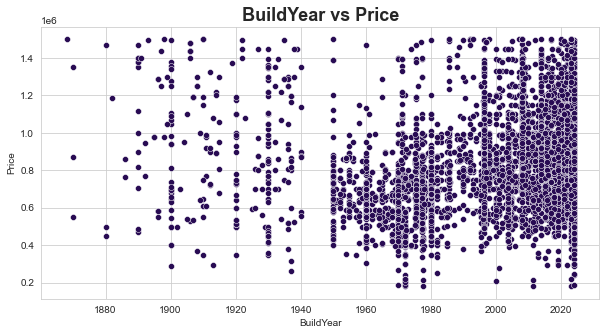

In [409]:
sns.scatterplot(data=df, x="BuildYear", y="Price")
plt.title("BuildYear vs Price", weight="bold", fontsize=18)
plt.show()

In [410]:
df["Age"] = pd.cut(df["BuildYear"], bins=[1850, 2000, 2016, 2024], labels=[0, 1, 2])

In [411]:
df["Age"].value_counts()

2    2936
0    2181
1    1460
Name: Age, dtype: int64

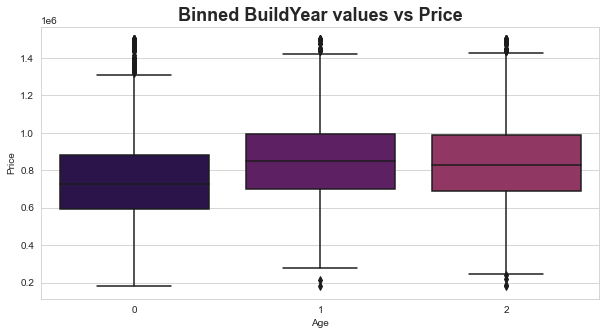

In [412]:
sns.boxplot(data=df, x="Age", y="Price")
plt.title("Binned BuildYear values vs Price", weight="bold", fontsize=18)
plt.show()

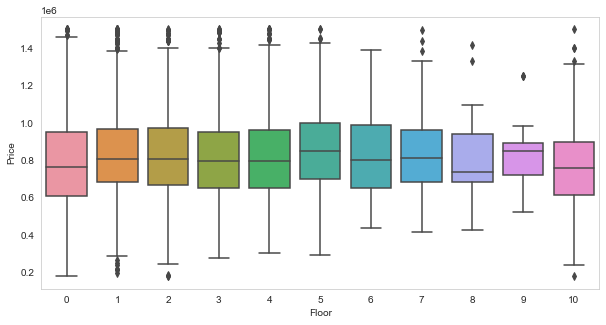

In [424]:
sns.boxplot(data=df, x="Floor", y="Price")
plt.show()

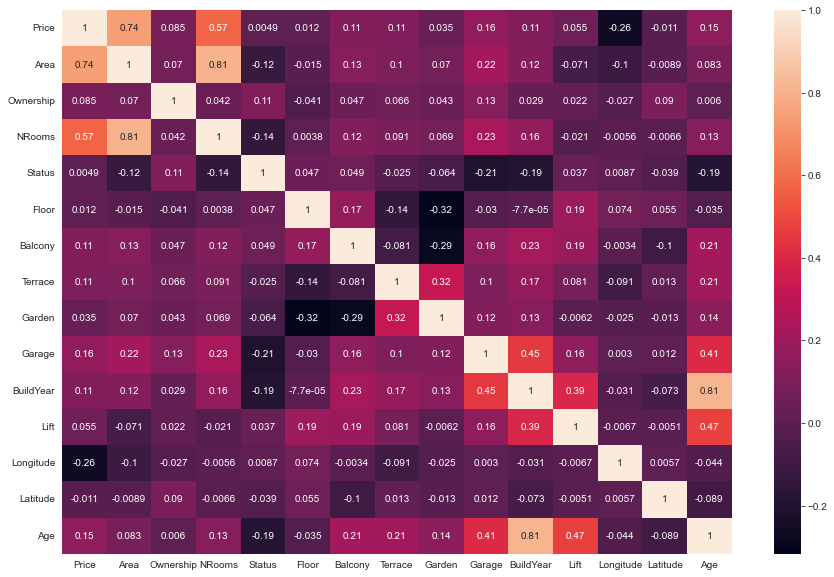

In [413]:
plt.figure(figsize=(15,10))
df["Age"] = df["Age"].astype("int")
sns.heatmap(df.corr(), annot=True)
plt.show()

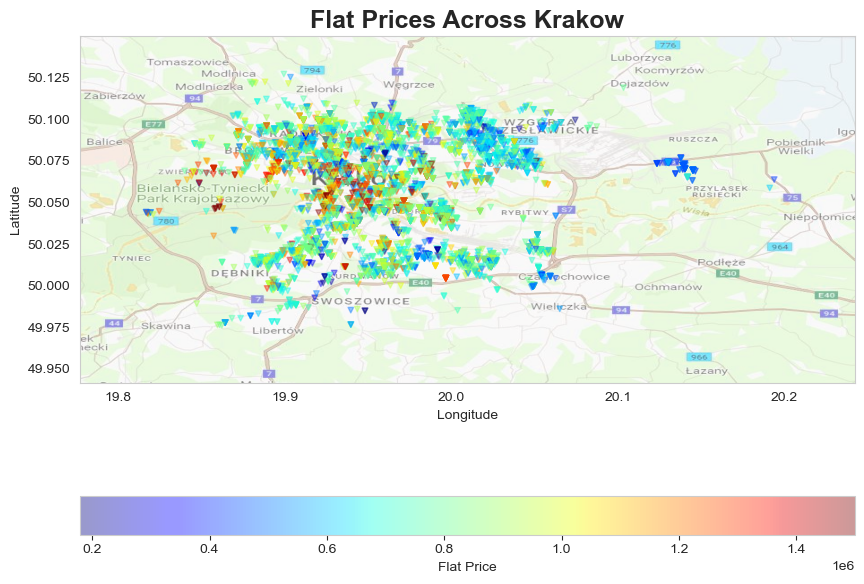

In [414]:
import cv2

krakow_map = cv2.imread("krk1.jpg")
plt.rcParams['axes.grid'] = False
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(krakow_map, extent=[19.777, 20.2423, 49.9417, 50.1497], alpha=0.7)
plt.scatter(df["Longitude"], df["Latitude"], alpha=0.4, c=df["Price"], cmap="jet", s=16, marker="v")

plt.title("Flat Prices Across Krakow", weight="bold", fontsize=18)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(orientation="horizontal", label="Flat Price")
plt.show()

# Modeling

---

In [415]:
features = ["Area", "Ownership", "NRooms", "Status", "Floor", "Balcony", "Terrace", "Garden", "Garage", "Lift", "Longitude", "Latitude", "Age"]

In [416]:
def print_results(y_test: np.array, y_pred: np.array, name: str = "Model") -> None:
    """
    Prints the results for the model predicted values.
    """
    printmd(f"**--- Results for {name} ---**")
    print("R2 Score:", r2_score(y_test, y_pred))
    print("RMSE:", root_mean_squared_error(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    printmd("--- --- ---")
    

def check_model(model, X: np.array, y: np.array, name: str = "Model") -> None:
    """
    Prints the cross-validated results for given model.
    """
    printmd(f"**--- Results for {name} ---**")
    print("R2 Score:", np.mean(cross_val_score(model, X, y, scoring="r2")))
    print("RMSE:", np.mean(-cross_val_score(model, X, y, scoring="neg_root_mean_squared_error")))
    print("MAE:", np.mean(-cross_val_score(model, X, y, scoring="neg_mean_absolute_error")))
    printmd("**--- --- ---**")

In [417]:
X = df.drop(["Price", "BuildYear", "City"], axis=1).values
y = np.ravel(df[["Price"]].values)

In [419]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6577 entries, 0 to 7738
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Price      6577 non-null   float64
 1   Area       6577 non-null   float64
 2   Ownership  6577 non-null   int32  
 3   NRooms     6577 non-null   int64  
 4   Status     6577 non-null   int32  
 5   Floor      6577 non-null   int32  
 6   Balcony    6577 non-null   int64  
 7   Terrace    6577 non-null   int64  
 8   Garden     6577 non-null   int64  
 9   Garage     6577 non-null   int32  
 10  BuildYear  6577 non-null   float64
 11  Lift       6577 non-null   int32  
 12  City       6577 non-null   object 
 13  Longitude  6577 non-null   float64
 14  Latitude   6577 non-null   float64
 15  Age        6577 non-null   int32  
dtypes: float64(5), int32(6), int64(4), object(1)
memory usage: 719.4+ KB


In [420]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [421]:
lr = LinearRegression()
rf = RandomForestRegressor()
svr = SVR()
gb = GradientBoostingRegressor()
ada = AdaBoostRegressor()

models = {"Linear Regression": lr, "Random Forest": rf, "Support Vector Machines": svr,
          "Gradient Boost": gb, "AdaBoost": ada}

for name, model in models.items():
    check_model(model, X, y, name)

**--- Results for Linear Regression ---**

R2 Score: 0.6036115753961376
RMSE: 150895.86515073612
MAE: 110753.26137258636


**--- --- ---**

**--- Results for Random Forest ---**

R2 Score: 0.847694925363845
RMSE: 93265.70247402947
MAE: 57396.86453860511


**--- --- ---**

**--- Results for Support Vector Machines ---**

R2 Score: -0.011328160633499262
RMSE: 241134.82813659095
MAE: 186894.1916124777


**--- --- ---**

**--- Results for Gradient Boost ---**

R2 Score: 0.7999863627429026
RMSE: 107184.10509723274
MAE: 74669.53705412005


**--- --- ---**

**--- Results for AdaBoost ---**

R2 Score: 0.5920985524623729
RMSE: 153047.87843650283
MAE: 121992.40198833724


**--- --- ---**

### Evaluating on test set
**Random Forest Regressor** did pretty good in cross-validation tests, I am going to hypertune this model, however let's first see how it performs on previously selected dataset.

---

In [422]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print_results(y_test, y_pred, "Random Forest")

**--- Results for Random Forest ---**

R2 Score: 0.8594225580434978
RMSE: 90535.90061099004
MAE: 55967.24125551239


--- --- ---

### Model works quite good on average prices, however it has problems with edgey values

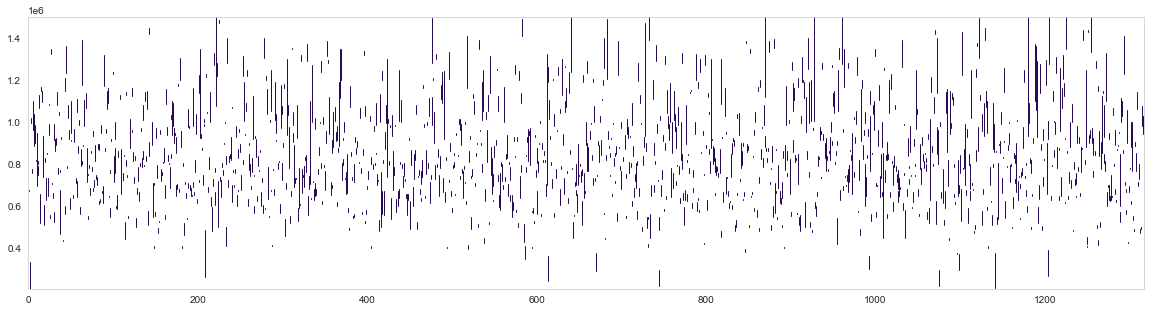

In [423]:
plot_residual_error(y_test, y_pred, points=False)

# Random Forest Hypertuning

I will try to improve model performance with **GridSearchCV**.

---

In [331]:
params = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [4, 6, 8]
}

rf_cv = GridSearchCV(RandomForestRegressor(random_state=42, oob_score=True),
                     params,
                     scoring="neg_root_mean_squared_error",
                     n_jobs=-1)

rf_cv.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='neg_root_mean_squared_error')

In [334]:
model1 = rf_cv.best_estimator_
print(-rf_cv.best_score_)
print(rf_cv.best_params_)

109364.14936001836
{'max_depth': 8, 'n_estimators': 100}


In [335]:
params = {
    "n_estimators": [100, 200],
    "max_depth": [8, 12, 14, 16, 18]
}

rf_cv = GridSearchCV(RandomForestRegressor(random_state=42, oob_score=True),
                     params,
                     scoring="neg_root_mean_squared_error",
                     n_jobs=-1)

rf_cv.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [8, 12, 14, 16, 18],
                         'n_estimators': [100, 200]},
             scoring='neg_root_mean_squared_error')

In [336]:
model1 = rf_cv.best_estimator_
print(-rf_cv.best_score_)
print(rf_cv.best_params_)

97293.9506118008
{'max_depth': 18, 'n_estimators': 200}


In [337]:
params = {
    "n_estimators": [200, 250],
    "max_depth": [18, 20, 22, 24, 26]
}

rf_cv = GridSearchCV(RandomForestRegressor(random_state=42, oob_score=True),
                     params,
                     scoring="neg_root_mean_squared_error",
                     n_jobs=-1)

rf_cv.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [18, 20, 22, 24, 26],
                         'n_estimators': [200, 250]},
             scoring='neg_root_mean_squared_error')

In [338]:
model1 = rf_cv.best_estimator_
print(-rf_cv.best_score_)
print(rf_cv.best_params_)

97258.68428600603
{'max_depth': 22, 'n_estimators': 200}


In [339]:
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)
print_results(y_test, y_pred)

**--- Results for Model ---**

R2 Score: 0.8608168695447993
RMSE: 90085.79345829118
MAE: 55553.35977770474


--- --- ---

ValueError: The number of FixedLocator locations (13), usually from a call to set_ticks, does not match the number of ticklabels (9).

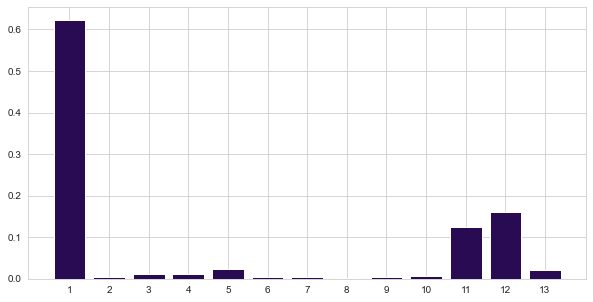

In [351]:
plt.bar(np.arange(1, 14), (model1.feature_importances_))
plt.xticks(np.arange(1, 14), features, rotation='vertical')
plt.show()

In [352]:
X_train.shape

(5261, 13)

# TODO

Floor bucketing
